# Paper Figures: Figure 2 - Photometry (Dopamine) Analysis

This notebook generates publication-ready figures for photometry data (dopamine responses) using data assembled by `src/assemble_all_data.py`.

**Figure 2: Photometry Analysis** — Neural responses showing dopamine heatmaps and summary plots for replete and deplete conditions across sodium concentrations.

In [6]:
%load_ext autoreload
%autoreload 2

import pathlib
from pathlib import Path
import sys
sys.path.insert(0, str(Path("../src").resolve()))
from pickle_compat import enable_dill_pathlib_compat
enable_dill_pathlib_compat()

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import dill


from figure_config import (
    configure_matplotlib, COLORS, HEATMAP_CMAP_DIV, 
    DATAFOLDER, RESULTSFOLDER, FIGSFOLDER,
    HEATMAP_VLIM_PHOTO, YLIMS_PHOTO,
    PHOTO_SMOOTH_WINDOW, SAVE_FIGS
)
from figure_plotting import (
    smooth_array, get_heatmap_data, get_mean_snips, get_auc,
    init_heatmap_figure, init_snips_figure, make_heatmap,
    plot_snips, plot_auc_summary, save_figure_atomic, print_auc_stats,
    scale_vlim_to_data, calculate_ylims, make_correlation_plot_da
)

# Configure matplotlib
configure_matplotlib()
colors = COLORS  # Use shared color palette
custom_cmap = HEATMAP_CMAP_DIV  # Use shared colormap

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Load Assembled Data

Load the complete dataset from the pickle file generated by the assembly script.

In [3]:
assembled_data_path = DATAFOLDER / "assembled_data.pickle"

with open(assembled_data_path, "rb") as f:
    data = dill.load(f)

# Extract main components
x_array = data["x_array"]
snips_photo = data["snips_photo"]
params = data.get("params", {})
metadata = data.get("metadata", {})

print(f"Loaded assembled data from {assembled_data_path}")
print(f"\nData structure:")
print(f"  - x_array shape: {x_array.shape}")
print(f"  - snips_photo shape: {snips_photo.shape}")
print(f"  - x_array columns: {x_array.columns.tolist()}")
print(f"  - Number of trials: {len(x_array)}") 

# Check data processing metadata
print(f"\nData processing metadata:")
if metadata:
    print(f"  Behaviour metric: {metadata.get('behav_metric', 'unknown')}")
    print(f"  Behaviour smoothed: {metadata.get('behav_smoothed', False)}")
    print(f"  Behaviour z-scored: {metadata.get('behav_zscored', False)}")
    print(f"  Photometry smoothed: {metadata.get('photo_smoothed', False)}")
    print(f"  Photometry z-scored: {metadata.get('photo_zscored', False)}")
else:
    print(f"  No metadata found; assuming standard processing")

# Store metadata flags for use during plotting
photo_already_smoothed = metadata.get('photo_smoothed', False)

Loaded assembled data from ..\data\assembled_data.pickle

Data structure:
  - x_array shape: (1960, 19)
  - snips_photo shape: (1960, 200)
  - x_array columns: ['trial', 'id', 'condition', 'infusiontype', 'sex', 'movement_mean', 'movement_std', 'angvel_mean', 'angvel_std', 'cluster_photo', 'clusterness_photo', 'euclidean_diff', 'auc_snips', 'auc_movement', 'auc_angvel', 'time_moving', 'time_above_angvel_threshold', 'time_moving_raw', 'trial_aligned']
  - Number of trials: 1960

Data processing metadata:
  Behaviour metric: unknown
  Behaviour smoothed: True
  Behaviour z-scored: False
  Photometry smoothed: False
  Photometry z-scored: True


## Figure 2: Photometry Analysis — Dopamine Responses

Analysis of neural dopamine responses showing heatmaps, snip time series, and summary AUC metrics across replete and deplete sodium conditions, separated by infusion type (10NaCl vs 45NaCl).

In [4]:
# Photometry (dopamine) data is NOT smoothed during assembly
# Do not apply any smoothing to maintain signal fidelity
snips_photo_smooth = snips_photo  # Use as-is, unsmoothed
print(f"Using unsmoothed photometry data (photometry is NOT smoothed during assembly)")

# Parameters for visualization
# Use dynamic scaling based on actual data instead of static limits
vlim = scale_vlim_to_data(snips_photo_smooth, percentile=80)
print("Based on data, vlim are:", vlim)
vlim = (-1, 1)  # Uncomment to override auto scaling with hardcoded values


Using unsmoothed photometry data (photometry is NOT smoothed during assembly)
Based on data, vlim are: (np.float64(-1.0892912373617631), np.float64(1.0892912373617631))


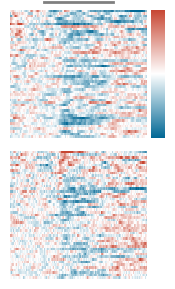

In [16]:
### 2A. Heatmaps — Replete Condition

f, ax1, ax2, cbar_ax = init_heatmap_figure()

# Replete + 10NaCl
heatmap_data_rep_10 = get_heatmap_data(snips_photo_smooth, x_array, "replete", "10NaCl")
replete_10_auc = get_auc(heatmap_data_rep_10)
make_heatmap(heatmap_data_rep_10, ax1, vlim, inf_bar=True, cmap=custom_cmap)

# Replete + 45NaCl
heatmap_data_rep_45 = get_heatmap_data(snips_photo_smooth, x_array, "replete", "45NaCl")
replete_45_auc = get_auc(heatmap_data_rep_45)
make_heatmap(heatmap_data_rep_45, ax2, vlim, cmap=custom_cmap, cbar_ax=cbar_ax)

if SAVE_FIGS:
    save_figure_atomic(f, "fig2_heatmap_dopamine_replete", FIGSFOLDER)


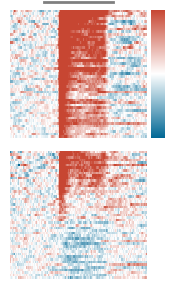

In [18]:
### 2B. Heatmaps — Deplete Condition

f, ax1, ax2, cbar_ax = init_heatmap_figure()

# Deplete + 10NaCl
heatmap_data_dep_10 = get_heatmap_data(snips_photo_smooth, x_array, "deplete", "10NaCl")
deplete_10_auc = get_auc(heatmap_data_dep_10)
make_heatmap(heatmap_data_dep_10, ax1, vlim, cmap=custom_cmap, inf_bar=True)

# Deplete + 45NaCl
heatmap_data_dep_45 = get_heatmap_data(snips_photo_smooth, x_array, "deplete", "45NaCl")
deplete_45_auc = get_auc(heatmap_data_dep_45)
make_heatmap(heatmap_data_dep_45, ax2, vlim, cmap=custom_cmap, cbar_ax=cbar_ax)

if SAVE_FIGS:
    save_figure_atomic(f, "fig2_heatmap_dopamine_deplete", FIGSFOLDER)


In [31]:

ylims = calculate_ylims(snips_photo_smooth)  # Calculate ylims based on data
print("Based on data, ylims are:", ylims)
ylims = (-0.6, 3)  # snips plot limits

Based on data, ylims are: (np.float64(-19.4143491470072), np.float64(10.967553936203522))


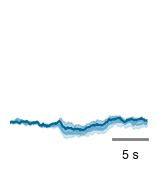

In [34]:
### 2C. Time Series Snips — Replete Condition

# Get animal-averaged snips for replete
snips_rep_10, snips_rep_45 = get_mean_snips(snips_photo_smooth, x_array, "replete")

f, ax = init_snips_figure()
plot_snips(snips_rep_10, snips_rep_45, ax, colors[0], colors[1], ylims)

if SAVE_FIGS:
    save_figure_atomic(f, "fig2_snips_dopamine_replete", FIGSFOLDER)


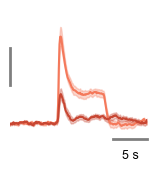

In [33]:
### 2D. Time Series Snips — Deplete Condition

# Get animal-averaged snips for deplete
snips_dep_10, snips_dep_45 = get_mean_snips(snips_photo_smooth, x_array, "deplete")

f, ax = init_snips_figure()
plot_snips(snips_dep_10, snips_dep_45, ax, colors[2], colors[3], ylims, scalebar=True)

if SAVE_FIGS:
    save_figure_atomic(f, "fig2_snips_dopamine_deplete", FIGSFOLDER)



Figure 2 — Dopamine Summary Statistics
Replete + 10NaCl (n=10)        (n=10):  -14.31 ± 8.27
Replete + 45NaCl (n=10)        (n=10):   -6.50 ± 8.39
Deplete + 10NaCl (n=10)        (n=10):   71.43 ± 6.55
Deplete + 45NaCl (n=10)        (n=10):   16.46 ± 5.10


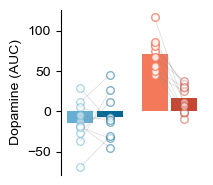

In [37]:
### 2E. AUC Summary — Bar Plot with Individual Data Points

# Organize AUCs by condition
replete_aucs = [get_auc(snips_rep_10), get_auc(snips_rep_45)]
deplete_aucs = [get_auc(snips_dep_10), get_auc(snips_dep_45)]
aucs = [replete_aucs, deplete_aucs]

f, ax = plot_auc_summary(aucs, colors, ylabel="Dopamine (AUC)")


if SAVE_FIGS:
    save_figure_atomic(f, "fig2_auc_dopamine_summary", FIGSFOLDER)

# Print summary statistics
auc_labels = [
    f"Replete + 10NaCl (n={len(snips_rep_10)})",
    f"Replete + 45NaCl (n={len(snips_rep_45)})",
    f"Deplete + 10NaCl (n={len(snips_dep_10)})",
    f"Deplete + 45NaCl (n={len(snips_dep_45)})"
]
auc_arrays = [replete_aucs[0], replete_aucs[1], deplete_aucs[0], deplete_aucs[1]]
print_auc_stats(auc_arrays, auc_labels, title="Figure 2 — Dopamine Summary Statistics")

r = 0.04, p = 0.796
r = -0.27, p = 0.060
r = -0.80, p = 0.000
r = -0.90, p = 0.000


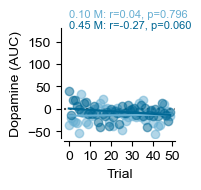

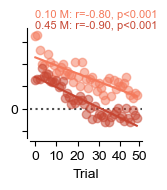

In [12]:
def make_auc_data_per_trial(x_array, condition, infusiontype):
    
    return (
        x_array
        .query("condition == @condition & infusiontype == @infusiontype")
        .groupby("trial")
        .auc_snips
        .mean()
        .values
    )
    
replete_10 = make_auc_data_per_trial(x_array, "replete", "10NaCl")
replete_45 = make_auc_data_per_trial(x_array, "replete", "45NaCl")
deplete_10 = make_auc_data_per_trial(x_array, "deplete", "10NaCl")
deplete_45 = make_auc_data_per_trial(x_array, "deplete", "45NaCl")

f = make_correlation_plot_da(replete_10, replete_45, colors[0], colors[1], yaxis=True)
if SAVE_FIGS:
    save_figure_atomic(f, "fig2_correlation_da_replete", FIGSFOLDER)
    
f = make_correlation_plot_da(deplete_10, deplete_45, colors[2], colors[3])
if SAVE_FIGS:
    save_figure_atomic(f, "fig2_correlation_da_deplete", FIGSFOLDER)

In [ ]:
x_array.columns

## Organization

This notebook generates **Figure 2 (Photometry Analysis)** only. Each figure has its own dedicated notebook:

- **figure_1_paper.ipynb**: Movement analysis
- **figure_2_paper.ipynb**: Photometry (dopamine) analysis (current)
- **figure_3_paper.ipynb**: Neural-behavioral correlation
- **figure_4_paper.ipynb**: Transition analysis
- **figure_5_paper.ipynb**: Cluster analysis

All notebooks share common settings and functions from:
- `src/figure_config.py` — Colors, paths, parameters
- `src/figure_plotting.py` — Data extraction and plotting functions

This keeps each figure focused and manageable, while reducing code duplication.

In [ ]:
# Configuration for Figure Saving
# ───────────────────────────────────────────────────────────────────────
# The SAVE_FIGS setting is loaded from figure_config.py
# Figures are saved in two formats:
#   - PDF for publication (vector format, smaller file size)
#   - PNG for presentations (raster format, high DPI for screen)
#
# All figures follow naming convention:
#   fig{number}_{description}.{pdf|png}
#
# Example:
#   fig2_heatmap_dopamine_replete.pdf
#   fig2_snips_dopamine_replete.png
# ───────────────────────────────────────────────────────────────────────

print(f"\nFigure saving is currently: {'ENABLED' if SAVE_FIGS else 'DISABLED'}")
print(f"Figure output folder: {FIGSFOLDER}")
if SAVE_FIGS:
    print("All generated figures will be saved in both PDF and PNG formats.")
else:
    print("To save figures, set SAVE_FIGS = True in src/figure_config.py")